In [1]:
from BMI_HBVmountain_Python import *
from Calibration_BRC import *
import os

## Load forcing and observation data

In [2]:
forcing = pd.read_csv('Data/BigCreek/forcing_bigrockcreek.csv', index_col=[0], parse_dates=True)
pd.to_datetime(forcing.index);
forcing = forcing.reset_index(level=0)
for i in range(len(forcing)):
    forcing['Date'][i] = forcing['Date'][i].date()
forcing.set_index('Date', inplace=True)


C:\Users\Vincent Hoogelander\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Loop through selected parametersets

In [6]:
oblist = []
param_list = parameter_conversion('output', nsmallest=25)
for p in range(len(param_list)):
    model = BMI_HBVmountain()

    config_file = model.setup()

    model.initialize(config_file)

    
    model.set_value('bare_parameters', param_list[p][0])
    model.set_value('forest_parameters', param_list[p][1])
    model.set_value('grass_parameters', param_list[p][2])
    model.set_value('rip_parameters', param_list[p][3])
    model.set_value('slow_parameters', param_list[p][4])

    model.set_value('Temperature', (forcing['temp_era5'].values).reshape(len(forcing),1))
    model.set_value('Precipitation', (forcing['prec_REGEN'].values).reshape(len(forcing),1))

    model.set_value('Date', list(forcing.index.values))
    model.set_value('Current_Date', forcing.index.values[0])

    model.set_value('Elevation', Main.Elevations(270, 1250, 2600, 1250, 1250))
    model.set_value('Glacier', [0.0, 0.0, 0.0, 0.0])
    model.set_value('Sunhours', [10.18, 10.90, 12.0, 13.10, 14.0, 14.45, 14.08, 13.31, 12.24, 11.25, 10.31, 9.85])
    model.set_value('bare_input', Main.HRU_Input([0,0,0,0], 0, np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
    model.set_value('forest_input', Main.HRU_Input([0.0,0.20,0.73,0.07], 0.64,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
    model.set_value('grass_input', Main.HRU_Input([0.1,0.8,0.1,0.0], 0.35,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
    model.set_value('rip_input', Main.HRU_Input([1.0,0,0,0], 0.01,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.2, np.zeros(4), 0, 0.0))
    model.set_value('Total_Elevationbands', 4)
    model.set_value('Elevation_Percentage', [0.16,0.46,0.33,0.05])
    model.set_value('bare_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
    model.set_value('forest_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
    model.set_value('grass_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
    model.set_value('rip_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

    Discharge = []
    timestamp = []
    while (model.get_value_ptr('Current_Date') < (model.get_value_ptr('Date')[-1])):  
    # while (model.get_value_ptr('Current_Date') < (datetime.date(1996, 1, 1))):  
        model.update()
        timestamp.append(model.get_value_ptr('Current_Date'))
        Discharge.append(model.get_value_ptr('Discharge'))

    simulated_discharge_df = pd.DataFrame(
        {'simulation': Discharge},
        index=pd.to_datetime(timestamp)
    )
    combined_discharge = pd.merge(simulated_discharge_df, forcing['streamflow'], left_index=True, right_index=True)
    
    
    oblist.append([multi_objective(combined_discharge.simulation[3652:-1], combined_discharge.streamflow[3652:-1], forcing.prec_REGEN)])
    


In [7]:
oblist

[[(0.5050779048268476,
   0.3949289361733358,
   0.7893820304165379,
   0.9212741167540611,
   0.2229890131455876)],
 [(0.4685486401556612,
   0.3969778920784468,
   0.7554269406244197,
   0.9155928834362332,
   0.33098945641657973)],
 [(0.5716595410132886,
   0.3537705671305007,
   0.7480699640977471,
   0.9691851604713503,
   0.09162356586359321)],
 [(0.6785586751469735,
   0.2930073492845555,
   0.7310589032808584,
   0.8442305295163766,
   -0.11594599011958029)],
 [(0.6758685767872262,
   0.3609332282813704,
   0.7039649368130765,
   0.9399913535293124,
   -0.15219321181447776)],
 [(0.5828088961309974,
   0.2940582740574108,
   0.7734254752777844,
   0.7843641839682745,
   0.12680111268843297)],
 [(0.45378506919482936,
   0.2563300134008606,
   0.8385106542092238,
   0.868294224579023,
   0.523331050890572)],
 [(0.5870311249656883,
   0.367375268750063,
   0.7611610902235826,
   0.8164045304569583,
   0.057950747113000634)],
 [(0.4785872435397675,
   0.38081432441235064,
   0.80016

NSE = 0.4108129300043927


## Clean up

In [ ]:
model.finalize()

In [ ]:
print(model)

In [64]:
directory = 'output'

bare_parametersets = pd.read_csv(os.path.join(directory, 'bare_paramsets.csv')).sort_values(by=['ED'])
# bare_parametersets = bare_parametersets.loc[bare_parametersets['ED'].isin(bare_parametersets.ED.nsmallest(25))]
forest_parametersets = pd.read_csv(os.path.join(directory, 'forest_paramsets.csv')).loc[bare_parametersets.index].sort_values(by=['ED'])
grass_parametersets = pd.read_csv(os.path.join(directory, 'grass_paramsets.csv')).loc[bare_parametersets.index].sort_values(by=['ED'])
rip_parametersets = pd.read_csv(os.path.join(directory, 'rip_paramsets.csv')).loc[bare_parametersets.index].sort_values(by=['ED'])
slow_parametersets = pd.read_csv(os.path.join(directory, 'slow_paramsets.csv')).loc[bare_parametersets.index].sort_values(by=['ED'])

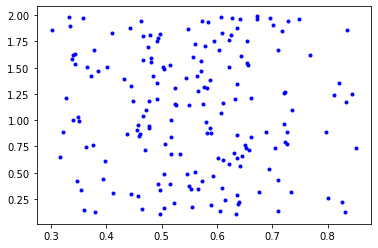

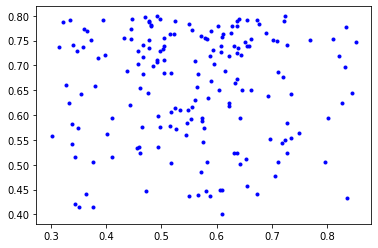

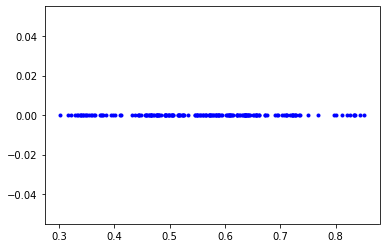

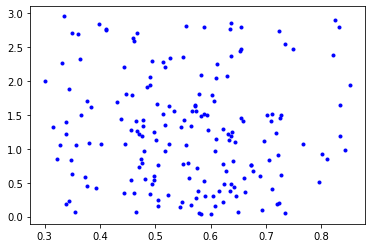

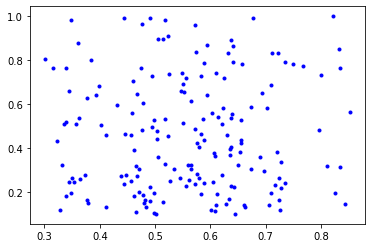

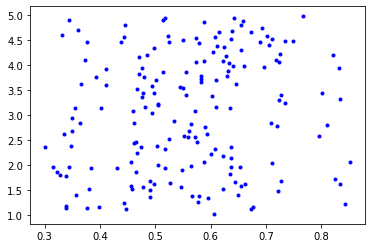

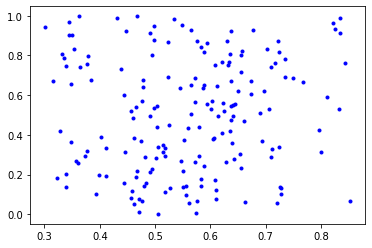

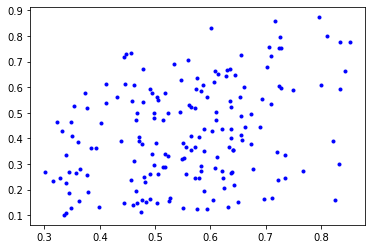

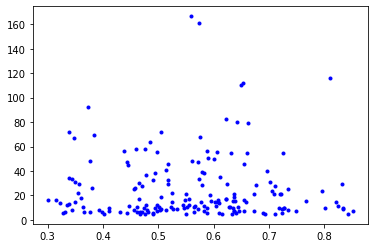

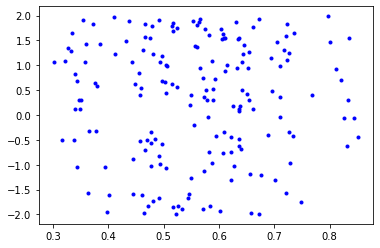

In [65]:
for i in np.arange(6, 16, 1):
    plt.figure()
    plt.xlabel='ED'
    for j in range(len(forest_parametersets)):
        plt.plot(forest_parametersets.iloc[j, 1], forest_parametersets.iloc[j, i], '.', color='blue')

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15])